<a href="https://colab.research.google.com/github/Flaviofrc97/DASCIENSE-MACHINE-LEARNING/blob/main/spaceship_predict_best_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [ ]:
!pip install scikit-learn-intelex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
!pip install optuna
!pip install vecstack

In [ ]:
#DataFrame
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#charts
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

#Preprocessig
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

#stacking
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from vecstack import stacking

#Models
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#tunning
import optuna
from optuna.samplers import TPESampler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


import warnings
warnings.filterwarnings( 'ignore' )

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,7)

## File and Data Field Descriptions

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## READ FILE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = "/content/drive/MyDrive/Datasests/SPACE/train.csv"
test = "/content/drive/MyDrive/Datasests/SPACE/test.csv"
sub="/content/drive/MyDrive/Datasests/SPACE/sample_submission.csv"

In [ ]:
train = pd.read_csv(train)
test = pd.read_csv(test)
sub = pd.read_csv(sub)

train['Transported'] = train['Transported'].astype(int)

## DESCRIPTION DATA

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [ ]:
train.shape, test.shape

((8693, 14), (4277, 13))

In [ ]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

# **Feature Engeeneing**

In [ ]:
TARGET = train[['Transported']]
train1 = train.copy()
test1 = test.copy()

In [ ]:
def fill_cat(df: pd.DataFrame):
    col_feat = list(train1.select_dtypes(exclude=['int64', 'float64']).columns)
    col_feat.remove('PassengerId')
    for col in col_feat:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df
        
def fill_num(df: pd.DataFrame):
    col_feat = list(train1.select_dtypes(include=['int64', 'float64']).columns)
    col_feat.remove('Transported')
    for col in col_feat:
        df[col].fillna(df[col].median(), inplace=True)
    return df
        
def convert_bainary(df: pd.DataFrame):
    cols = ['VIP','CryoSleep']
    for col in cols:
        df[col] = df[col].astype(int)
    return df

#off
def log_transform(df: pd.DataFrame):
    col_feat = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'vr_spend' ]
    for col in col_feat:
        df[col] = np.log(1+df[col])
    return df

In [ ]:
def create_columns(df: pd.DataFrame):
    df['deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['num'] = df['Cabin'].apply(lambda x: x.split('/')[1])
    df['side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    df['LastName'] = df.Name.str.split(' ').str[1]
    
    df['group'] = df['PassengerId'].apply(lambda x: x[0:4])
    df['vr_spend']=df['RoomService']+df['FoodCourt']+df['ShoppingMall']+df['Spa']+df['VRDeck']
    df['no_spend'] = df['vr_spend'].apply(lambda row: 1 if row == 0 else 0)
    
    df['familyCounts'] = df.groupby(['LastName'])['LastName'].transform('count')
    # fill the values with name 'Disivering'
    df['familyCounts'] =  df['familyCounts'].apply(lambda x: 0 if x > 200 else x)
    
    #df['isChild'] = df['Age'].apply(lambda x: 1 if x < 10 else 0)
    #df['isOld'] = df['Age'].apply(lambda x: 1 if x > 60 else 0)
    #new columns form Age
    df['0_18'] = df['Age'].apply(lambda x: 1 if x <= 18 else 0)
    df['19_30'] = df['Age'].apply(lambda x: 1 if x > 18 and x <= 30  else 0)
    df['more_30'] = df['Age'].apply(lambda x: 1 if x > 30 else 0)
    
    return df

def drop_cols(df: pd.DataFrame):
    df.drop(['Name', 'Cabin', 'Age', 'LastName'], axis=1, inplace=True)
    return df


def reduce_cardinality(df: pd.DataFrame ):
    col_ = ['Cabin', 'deck','num', 'side']
    for col in col_:
        #get a list of categories which contain one value
        tmp=list(df[col].value_counts()[df[col].value_counts()<2].index)
        #Replace with 'other'
        df[col]=df[col].apply(lambda x:'other' if x in tmp else x)
    return df

In [ ]:
%%time
train1 = (train1.pipe(fill_cat).pipe(fill_num).pipe(convert_bainary))
test1 = (test1.pipe(fill_cat).pipe(fill_num).pipe(convert_bainary))

train1 = (train1.pipe(create_columns).pipe(drop_cols))
test1 = (test1.pipe(create_columns).pipe(drop_cols))

CPU times: user 121 ms, sys: 3.02 ms, total: 125 ms
Wall time: 124 ms


In [ ]:
train1.head()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,deck,num,side,group,vr_spend,no_spend,familyCounts,0_18,19_30,more_30
0,0001_01,Europa,0,TRAPPIST-1e,0,0.0,0.0,0.0,0.0,0.0,...,B,0,P,0001,0.0,1,1,0,0,1
1,0002_01,Earth,0,TRAPPIST-1e,0,109.0,9.0,25.0,549.0,44.0,...,F,0,S,0002,736.0,0,4,0,1,0
2,0003_01,Europa,0,TRAPPIST-1e,1,43.0,3576.0,0.0,6715.0,49.0,...,A,0,S,0003,10383.0,0,6,0,0,1
3,0003_02,Europa,0,TRAPPIST-1e,0,0.0,1283.0,371.0,3329.0,193.0,...,A,0,S,0003,5176.0,0,6,0,0,1
4,0004_01,Earth,0,TRAPPIST-1e,0,303.0,70.0,151.0,565.0,2.0,...,F,1,S,0004,1091.0,0,6,1,0,0


# **EDA**

## **LABEL ENCODER**

In [ ]:
cats = list(train1.select_dtypes(exclude=['int64', 'float64']).columns)
cats.remove('PassengerId')
for i in cats:
    print(i)
    le=LabelEncoder()
    arr=np.concatenate((train1[i], test1[i])).astype(str)
    le.fit(arr)
    train1[i]=le.transform(train1[i].astype(str))
    test1[i]=le.transform(test1[i].astype(str))

HomePlanet
Destination
deck
num
side
group


## **TARGET**

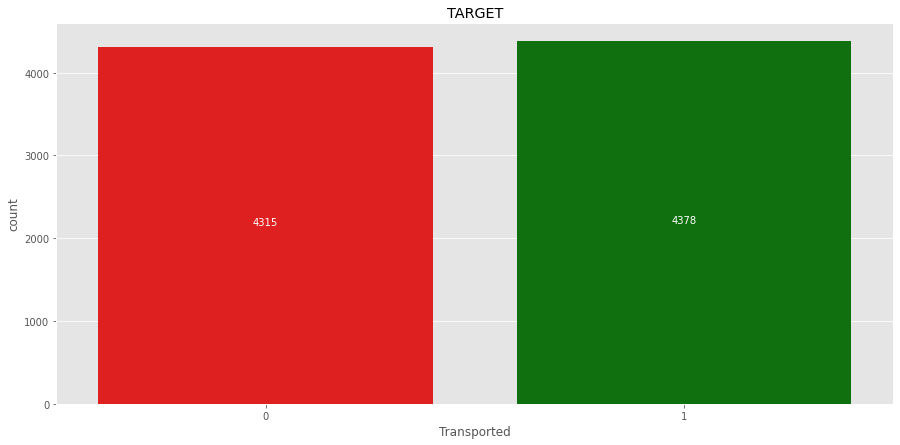

In [ ]:
g = sns.countplot(x = 'Transported', data = train , palette=['g' if c == True else 'r' for c in train['Transported']]);
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{}'.format(round(height)),
            ha="center", color='white')
plt.title('TARGET');

**We have a balanced class**

## **Bivariate Analysis**

In [ ]:
num_feat = train1.select_dtypes(exclude='object')
num_feat.drop('Transported', axis=1, inplace=True)

 ## **Numerical Variable**

In [ ]:
num_feat.describe()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,deck,num,side,LastName,group,vr_spend,no_spend,familyCounts,isChild,isOld
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.649833,0.349362,4819.036466,1.494306,28.790291,0.022892,220.009318,448.434027,169.572300,304.588865,...,4.344185,1011.745197,0.516162,1194.661452,4632.389624,1440.866329,0.420223,5.297596,0.078109,0.025308
std,0.795183,0.476796,3032.501554,0.814966,14.341404,0.149568,660.519050,1595.790627,598.007164,1125.562559,...,1.775938,535.059773,0.499767,689.883384,2671.028856,2803.045694,0.493623,2.975454,0.268358,0.157067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1968.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,531.000000,0.000000,626.000000,2318.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,0.000000,0.000000,4815.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1084.000000,1.000000,1194.000000,4629.000000,716.000000,0.000000,5.000000,0.000000,0.000000
75%,1.000000,1.000000,7563.000000,2.000000,37.000000,0.000000,41.000000,61.000000,22.000000,53.000000,...,6.000000,1438.000000,1.000000,1770.000000,6882.000000,1441.000000,1.000000,7.000000,0.000000,0.000000
max,2.000000,1.000000,9822.000000,2.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,...,7.000000,1893.000000,1.000000,2405.000000,9279.000000,35987.000000,1.000000,18.000000,1.000000,1.000000


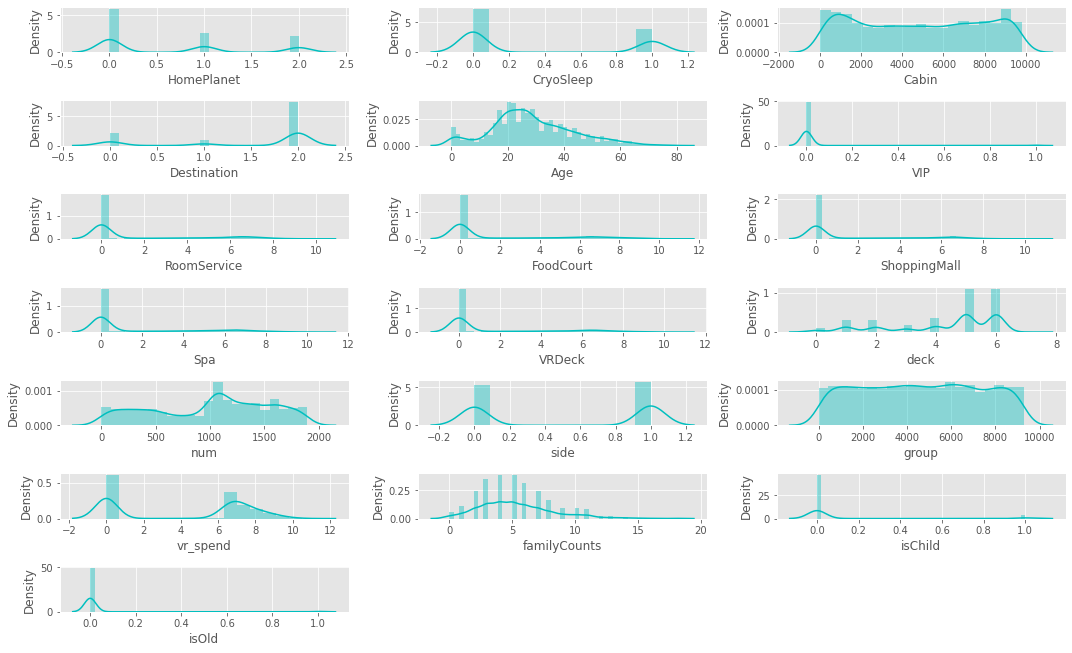

In [ ]:
plt.figure(figsize=(15,10));
for i, feat in enumerate(num_feat):
    plt.subplot( 8, 3, i + 1 );
    sns.distplot(x=num_feat[feat], color = 'c')
    plt.xlabel(feat);
    plt.tight_layout();

**As we can see, some columns doesnt have a normal curve.**

## **MULTIVARIETED ANALYSI**S

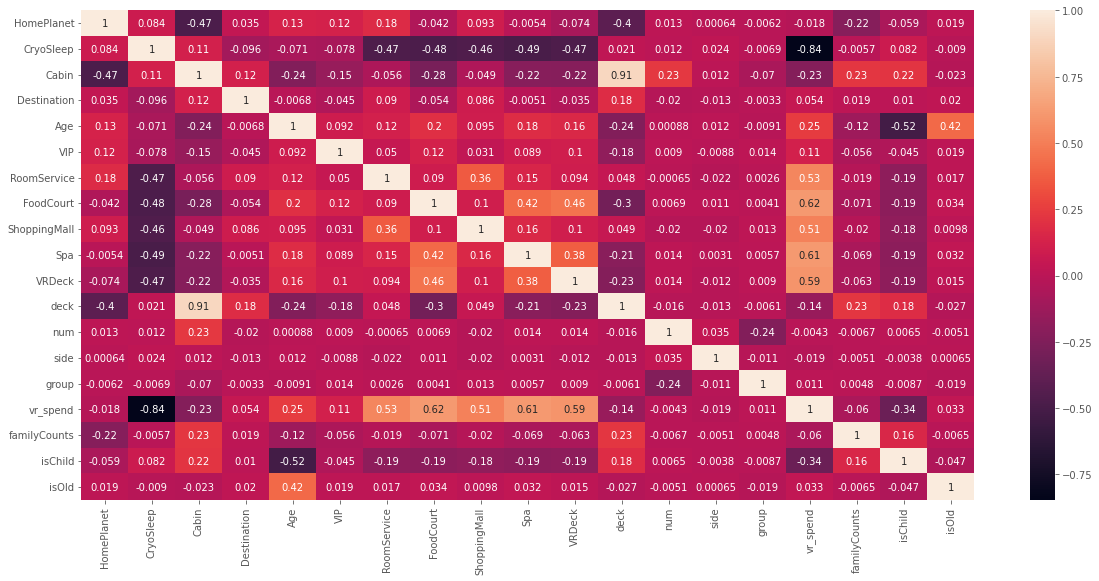

In [ ]:
plt.figure(figsize=(20,9));
num_corr = num_feat.corr();
sns.heatmap(num_corr, annot=True);

## **CHECK OUTLIERS**

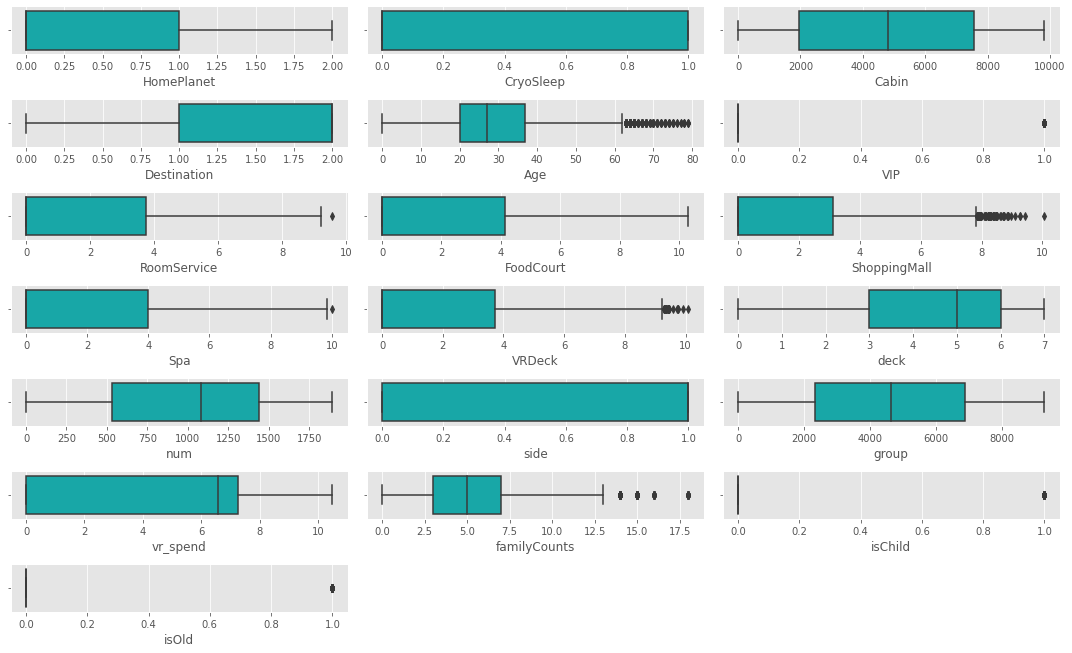

In [ ]:
plt.figure(figsize=(15,10));
for i, feat_num in enumerate(num_feat):
    plt.subplot( 8, 3, i + 1 );
    sns.boxplot(x=num_feat[feat_num], color = 'c')
    plt.xlabel(feat_num);
    plt.tight_layout()

## **STANDARD SCALER**

In [ ]:
X = train1.drop(['PassengerId', 'Transported'],axis=1)
X_test1 = test1.drop('PassengerId', axis=1)
y = TARGET

cols = list(X.columns)
#cols.remove('Transported')

# Feature Scaling

sc = StandardScaler()
X[cols] = sc.fit_transform(X[cols])
X_test1[cols] = sc.transform(X_test1[cols])

In [ ]:
X.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,group,vr_spend,no_spend,familyCounts,0_18,19_30,more_30
0,0.440385,-0.73277,0.620545,-0.153063,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.883161,-1.891010,-1.032865,-1.734409,-0.514066,1.174601,-1.444433,-0.522628,-0.804767,1.244395
1,-0.817259,-0.73277,0.620545,-0.153063,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,0.369299,-1.891010,0.968181,-1.734034,-0.251479,-0.851353,-0.436125,-0.522628,1.242596,-0.803603
2,0.440385,-0.73277,0.620545,6.533255,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-2.446276,-1.891010,0.968181,-1.733660,3.190333,-0.851353,0.236080,-0.522628,-0.804767,1.244395
3,0.440385,-0.73277,0.620545,-0.153063,-0.333105,0.523010,0.336851,2.687176,-0.092818,-2.446276,-1.891010,0.968181,-1.733660,1.332604,-0.851353,0.236080,-0.522628,-0.804767,1.244395
4,-0.817259,-0.73277,0.620545,-0.153063,0.125652,-0.237159,-0.031059,0.231374,-0.261240,0.369299,-1.889141,0.968181,-1.733286,-0.124824,-0.851353,0.236080,1.913407,-0.804767,-0.803603


## STACKING

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

### **KNN**

In [ ]:
# Which hyperparameters to tune: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

def objective(trial):              
    # -- Tune estimator algorithm
    n_neighbors = trial.suggest_int("n_neighbors", 1, 80)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
        
    # -- Make a pipeline
    pipeline = make_pipeline(knn)

    # -- Cross-validate the features reduced by dimensionality reduction methods
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=kfold)
    score = score.mean()
    return score

sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=300)

[I 2022-04-07 13:22:24,694] A new study created in memory with name: no-name-53dc2a5c-4ac9-45d0-8c52-ba0b0616761f
[I 2022-04-07 13:22:25,207] Trial 0 finished with value: 0.7684402735341191 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7684402735341191.
[I 2022-04-07 13:22:25,603] Trial 1 finished with value: 0.7653341798605876 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7684402735341191.
[I 2022-04-07 13:22:26,316] Trial 2 finished with value: 0.7678635768421888 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7684402735341191.
[I 2022-04-07 13:22:26,889] Trial 3 finished with value: 0.7641826382550957 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7684402735341191.
[I 2022-04-07 13:22:29,108] Trial 4 finished with value: 0.778

In [ ]:
study.best_params

{'metric': 'manhattan', 'n_neighbors': 70, 'weights': 'distance'}

### **XGB**

In [ ]:
def objective(trial):
  max_depth = trial.suggest_int("max_depth", 2, 15)
  n_estimators = trial.suggest_int("n_estimators", 1, 300)
  learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
  gamma = trial.suggest_uniform('gamma', 0.0000001, 1)
  subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)

  XGB = XGBClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        gamma=gamma, 
        subsample=subsample,
        random_state=666)
    # -- Make a pipeline
  pipeline = make_pipeline(XGB)

    # -- Cross-validate the features reduced by dimensionality reduction methods
  kfold = StratifiedKFold(n_splits=10)
  score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=kfold)
  score = score.mean()
  return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2022-04-07 13:35:53,274] A new study created in memory with name: no-name-36d626a1-9b07-4c3d-876d-b565dec8d8ef
[I 2022-04-07 13:36:21,188] Trial 0 finished with value: 0.6747980900228827 and parameters: {'max_depth': 7, 'n_estimators': 286, 'learning_rate': 0.7319939686120109, 'gamma': 0.5986585243311882, 'subsample': 0.15610303857839228}. Best is trial 0 with value: 0.6747980900228827.
[I 2022-04-07 13:36:23,244] Trial 1 finished with value: 0.7167912648968957 and parameters: {'max_depth': 4, 'n_estimators': 18, 'learning_rate': 0.8661761591573206, 'gamma': 0.6011150516317076, 'subsample': 0.7081017705382658}. Best is trial 1 with value: 0.7167912648968957.
[I 2022-04-07 13:36:35,414] Trial 2 finished with value: 0.6827341507612131 and parameters: {'max_depth': 2, 'n_estimators': 291, 'learning_rate': 0.8324426575561577, 'gamma': 0.2123391894443651, 'subsample': 0.1819067847103799}. Best is trial 1 with value: 0.7167912648968957.
[I 2022-04-07 13:36:43,486] Trial 3 finished with va

In [ ]:
study.best_params

{'gamma': 0.052247553628855456,
 'learning_rate': 0.04935493451934547,
 'max_depth': 4,
 'n_estimators': 38,
 'subsample': 0.15830998651277145}

### **LGBM**

In [ ]:
def objective(trial):
  max_depth = trial.suggest_int("max_depth", 2, 50)
  n_estimators = trial.suggest_int("n_estimators", 1, 300)
  learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
  num_leaves = trial.suggest_int("num_leaves", 2, 3000)
  min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
  LGBM = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=666
     )
    # -- Make a pipeline
  pipeline = make_pipeline(LGBM)

    # -- Cross-validate the features reduced by dimensionality reduction methods
  kfold = StratifiedKFold(n_splits=10)
  score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=kfold)
  score = score.mean()
  return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200)

In [ ]:
study.best_params

NameError: ignored

### **RF**

In [ ]:
def objective(trial):
  max_depth = trial.suggest_int("max_depth", 2, 70)
  n_estimators = trial.suggest_int("n_estimators", 2, 300)
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
  RF = RandomForestClassifier(
        min_samples_leaf=min_samples_leaf, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=666
    )
    # -- Make a pipeline
  pipeline = make_pipeline(RF)

    # -- Cross-validate the features reduced by dimensionality reduction methods
  kfold = StratifiedKFold(n_splits=10)
  score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=kfold)
  score = score.mean()
  return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=300)

[I 2022-04-07 13:16:22,070] A new study created in memory with name: no-name-2322940d-7114-4ede-9e2a-b10aa6ec968d
[I 2022-04-07 13:16:32,645] Trial 0 finished with value: 0.7746539158499002 and parameters: {'max_depth': 27, 'n_estimators': 286, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7746539158499002.
[I 2022-04-07 13:16:35,337] Trial 1 finished with value: 0.7735034324034761 and parameters: {'max_depth': 43, 'n_estimators': 48, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7746539158499002.
[I 2022-04-07 13:16:40,864] Trial 2 finished with value: 0.7738444241630623 and parameters: {'max_depth': 6, 'n_estimators': 260, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.7746539158499002.
[I 2022-04-07 13:16:41,289] Trial 3 finished with value: 0.7747703133473539 and parameters: {'max_depth': 50, 'n_estimators': 8, 'min_samples_leaf': 20}. Best is trial 3 with value: 0.7747703133473539.
[I 2022-04-07 13:16:44,872] Trial 4 finished with value: 0.773963334788302 

KeyboardInterrupt: ignored

In [ ]:
study.best_params

{'max_depth': 30, 'min_samples_leaf': 9, 'n_estimators': 193}

### **ET**

In [ ]:
from sklearn import svm

In [ ]:
def objective(trial):

   c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
   SVR_model = svm.SVC(C=c, gamma='auto', random_state=0)

   pipeline = make_pipeline(SVR_model)

   kfold = StratifiedKFold(n_splits=10)

   score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=kfold)
   score = score.mean()
   return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=300)

[I 2022-04-07 14:10:50,621] A new study created in memory with name: no-name-f1997ff8-eadd-44f3-8ebe-c2a6ac87ed0b
[I 2022-04-07 14:11:05,017] Trial 0 finished with value: 0.7457738449532425 and parameters: {'svc_c': 0.0030960101581081526}. Best is trial 0 with value: 0.7457738449532425.


### **BEST PARAMS**

In [ ]:
KNN_param = {'metric': 'manhattan', 'n_neighbors': 70, 'weights': 'distance'}

XGB_param = {'gamma': 0.052247553628855456,'learning_rate': 0.04935493451934547,'max_depth': 4,'n_estimators': 38, 'subsample': 0.15830998651277145}

LGBM_param = {'learning_rate': 0.09484585697022896,'max_depth': 38,'min_child_samples': 200,'n_estimators': 18,'num_leaves': 540}

MLP_params =  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(S_train, y) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
models = [
          KNeighborsClassifier(**KNN_param),
          LGBMClassifier(**LGBM_param),
          XGBClassifier(**XGB_param),
           MLPClassifier(**MLP_params),
        ]

In [ ]:
S_train, S_test = stacking(models,                   
                           X, y, X_test1,   
                           regression=False, 
     
                           mode='oof_pred_bag',
       
                           needs_proba=False,
         
                           save_dir="/content", 
            
                           metric=accuracy_score, 
    
                           n_folds=10, 
                 
                           stratified=False,
            
                           shuffle=True,  
            
                           random_state=24,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.80114943]
    fold  1:  [0.78275862]
    fold  2:  [0.78505747]
    fold  3:  [0.77560414]
    fold  4:  [0.79976985]
    fold  5:  [0.77100115]
    fold  6:  [0.76869965]
    fold  7:  [0.77790564]
    fold  8:  [0.77330265]
    fold  9:  [0.78250863]
    ----
    MEAN:     [0.78177572] + [0.01059875]
    FULL:     [0.78177844]

model  1:     [LGBMClassifier]
    fold  0:  [0.80804598]
    fold  1:  [0.81149425]
    fold  2:  [0.80344828]
    fold  3:  [0.81012658]
    fold  4:  [0.78711162]
    fold  5:  [0.79171461]
    fold  6:  [0.78941312]
    fold  7:  [0.80207135]
    fold  8:  [0.78941312]
    fold  9:  [0.77905639]
    ----
    MEAN:     [0.79718953] + [0.01064967]
    FULL:     [0.79719314]

model  2:     [XGBClassifier]
    fold  0:  [0.81264368]
    fold  1:  [0.80229885]
    fold  2:  [0.78620

### TUNNING THE PARAMS TO META LEARNER MODEL

In [ ]:
def objective(trial):
  max_depth = trial.suggest_int("max_depth", 2, 80)
  n_estimators = trial.suggest_int("n_estimators", 1, 300)
  learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
  num_leaves = trial.suggest_int("num_leaves", 2, 3000)
  min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
  LGBM = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=666
     )
    # -- Make a pipeline
  pipeline = make_pipeline(LGBM)

    # -- Cross-validate the features reduced by dimensionality reduction methods
  kfold = StratifiedKFold(n_splits=10)
  score = cross_val_score(pipeline, S_train, y, scoring='accuracy', cv=kfold)
  score = score.mean()
  return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200)

In [ ]:
study.best_params

{'learning_rate': 0.6144581876296981,
 'max_depth': 15,
 'min_child_samples': 140,
 'n_estimators': 161,
 'num_leaves': 583}

In [ ]:
LGBM_param_meta_learner = {'learning_rate': 0.6144581876296981,
 'max_depth': 15,
 'min_child_samples': 140,
 'n_estimators': 161,
 'num_leaves': 583}

### **FIT AND PREDICT**

In [ ]:
model = LGBMClassifier(**XGB_param, random_state=0) 
    
model = model.fit(S_train, y)
y_pred_LGBM = model.predict(S_test)

In [ ]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
MLP = MLPClassifier(**MLP_params, random_state=0) 
    
MLP = MLP.fit(S_train, y)
y_pred_MLP = MLP.predict(S_test)

In [ ]:
submission = pd.DataFrame({
        "PassengerId": sub["PassengerId"],
        "Transported":  y_pred_MLP})

submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('pred_MLP_ULTUMOO.csv', index=False)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [ ]:
MLP_ALONE = MLPClassifier(**MLP_params, random_state=0) 
    
MLP_ALONE = MLP_ALONE.fit(X, y)
y_pred_MLP_ALONE = MLP_ALONE.predict(X_test1)

In [ ]:
submission = pd.DataFrame({
        "PassengerId": sub["PassengerId"],
        "Transported":  y_pred_MLP_ALONE})

submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('pred_MLP_ALONE.csv', index=False)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


**XGB, LGBM, KNN, MLP - MLP AS NETA LEARNER = 0.80734**